# **Q7. Jamboree Education - Linear Regression**

## **Problem Statement:**
### 1. Help Jamboree in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import missingno as msno

In [2]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]

In [3]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<5:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<5:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [5]:
def model_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metric = ['R Squared', 'Adjusted R Squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error']
    score = [r2_score(y_test, y_pred)]
    score += [1-(1-r2_score(y_test, y_pred))*(len(features)-1)/(len(features)-len(features.columns)-1)]
    score += [mean_absolute_error(y_test, y_pred)]
    score += [mean_squared_error(y_test, y_pred)]
    score += [mean_squared_error(y_test, y_pred, squared=False)]
    return pd.DataFrame({'Metric Name':metric, 'Metric Score':score})

In [6]:
def vif_pruning(features, vif_threshold):
    vifs = []
    columns = []
    result = []
    feature_columns = features.columns
    for column in feature_columns:
        if len(features.columns) <=1:
            vifs += [0]
            columns += [column]
            result += ["Keeping column"]
            break
        vif = round(variance_inflation_factor(features.values, features.columns.get_loc(column)), 2)
        vifs += [vif]
        columns += [column]
        if vif > vif_threshold:
            features = features.drop(column, axis=1)
            result += ["Dropping column"]
        else:
            result += ["Keeping column"]
    return features, pd.DataFrame({'VIF Score':vifs, 'Column Name':columns, 'Result':result})

***
***
## **1. Analyzing Basic Metrics.**

In [7]:
filename = 'Jamboree_Admission.csv'
df = pd.read_csv(filename)
df = convert_to_best_type(df)

In [8]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [9]:
df = df.drop('Serial No.', axis=1)

In [10]:
print("Shape:", df.shape, "\n")

Shape: (500, 8) 



In [11]:
df.dtypes

GRE Score               int64
TOEFL Score             int64
University Rating       int64
SOP                   float64
LOR                   float64
CGPA                  float64
Research             category
Chance of Admit       float64
dtype: object

***
***
## **2. Missing Values.**

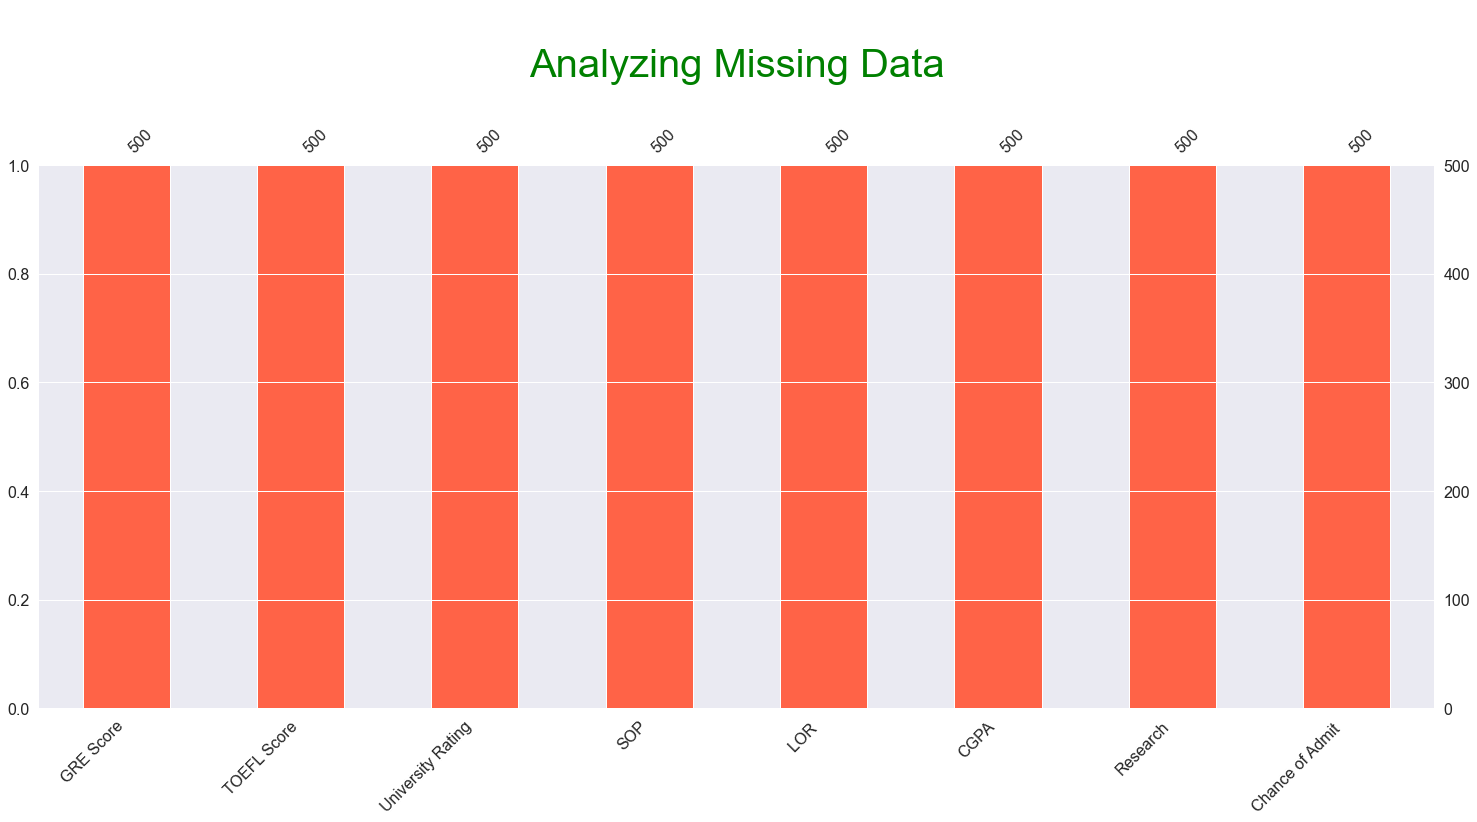

In [12]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

***
***
## **3. Outlier Detection & Treatment.**

In [13]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,0.97000


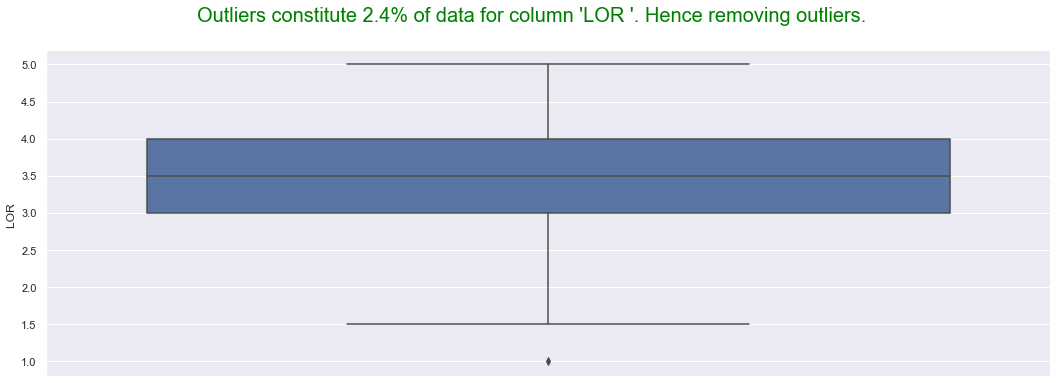

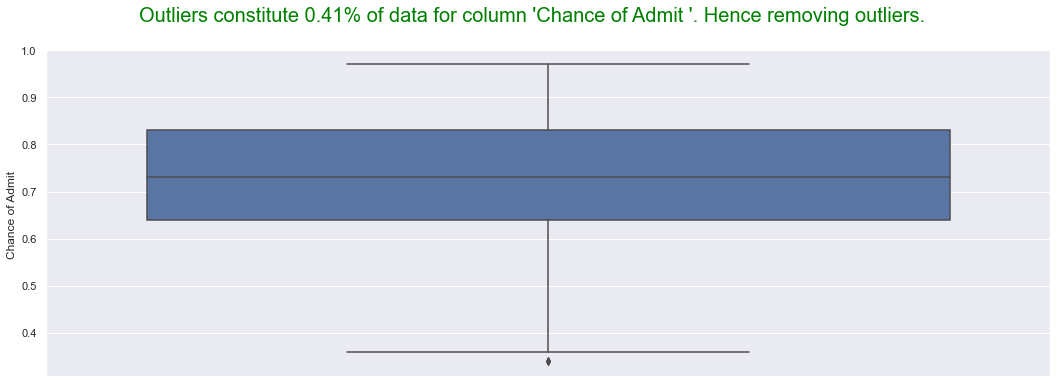

In [14]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column)

***
***
## **4. Univariate Analysis (Categorical Data).**

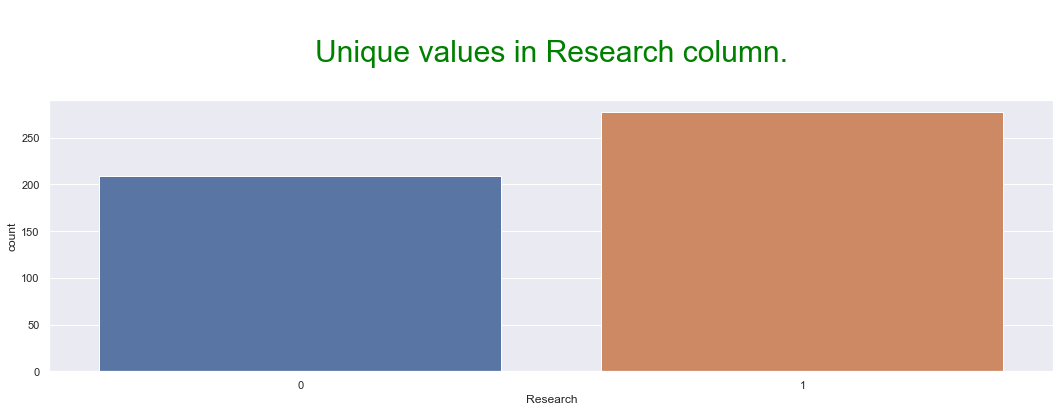

In [15]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **5. Univariate Analysis (Discrete Data).**

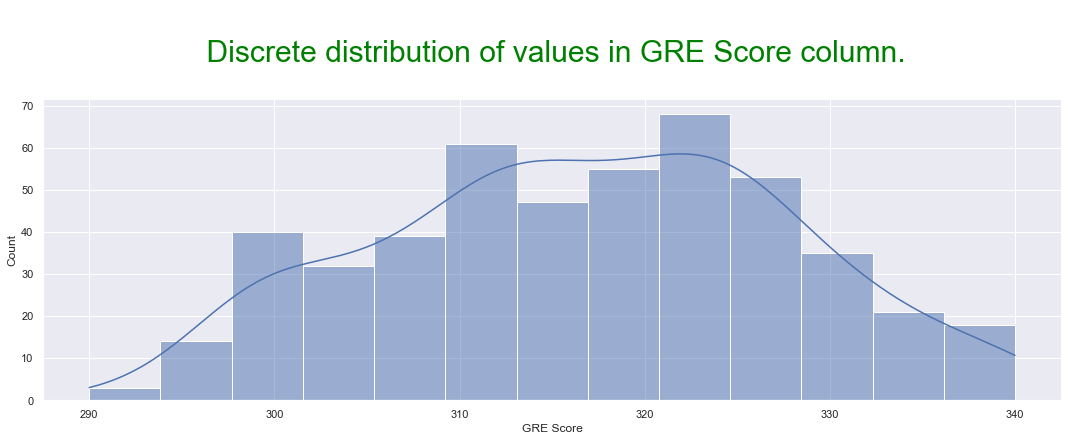

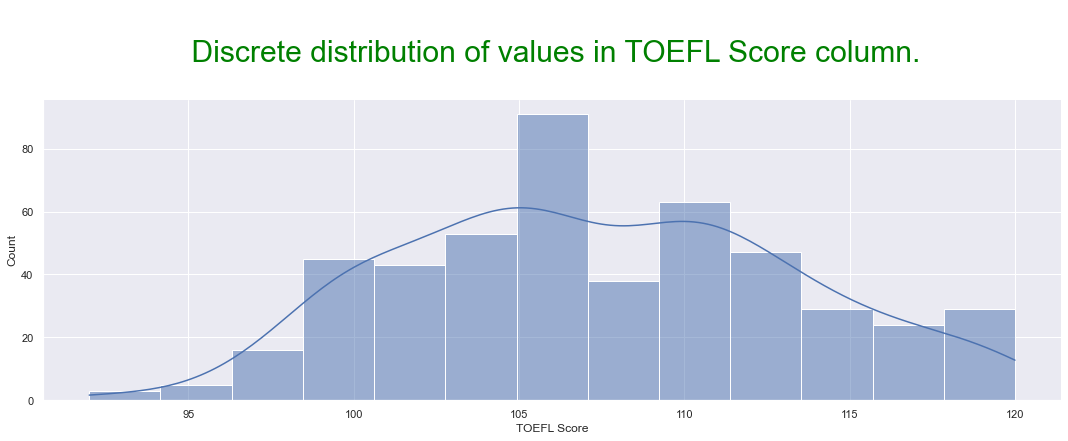

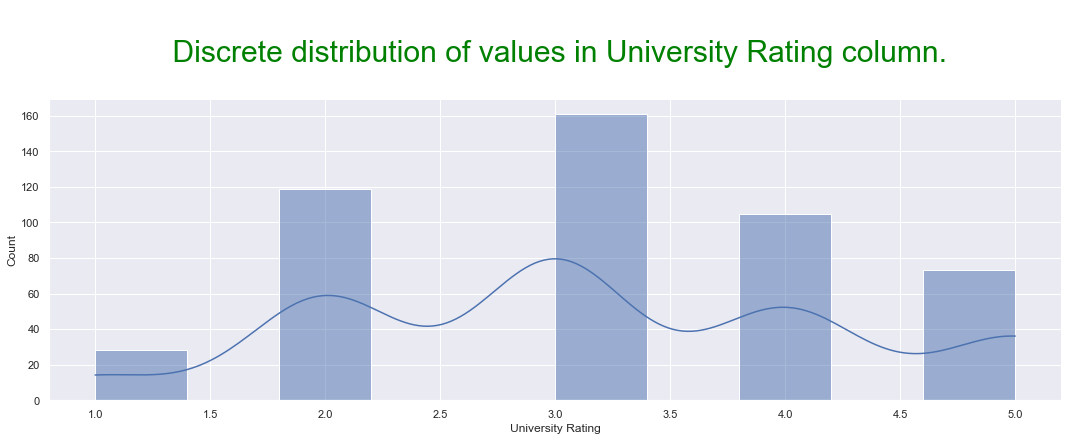

In [16]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Univariate Analysis (Continuous Data).**

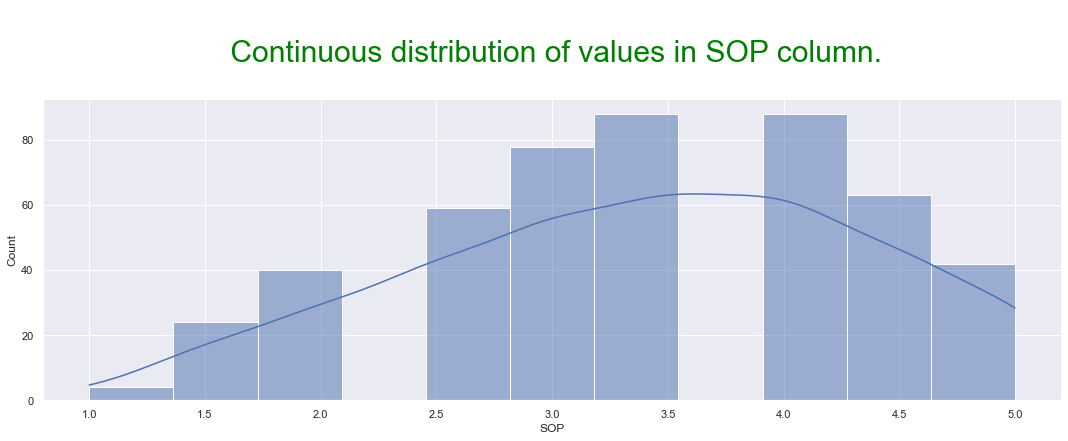

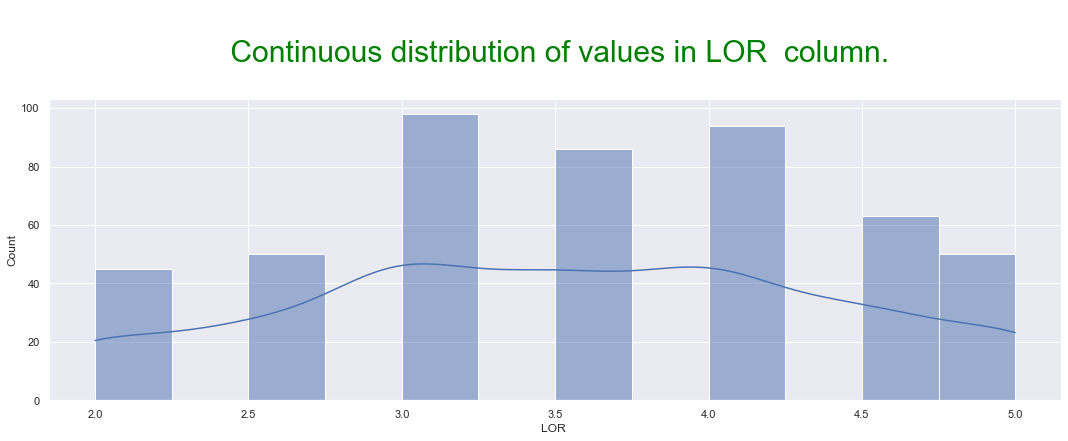

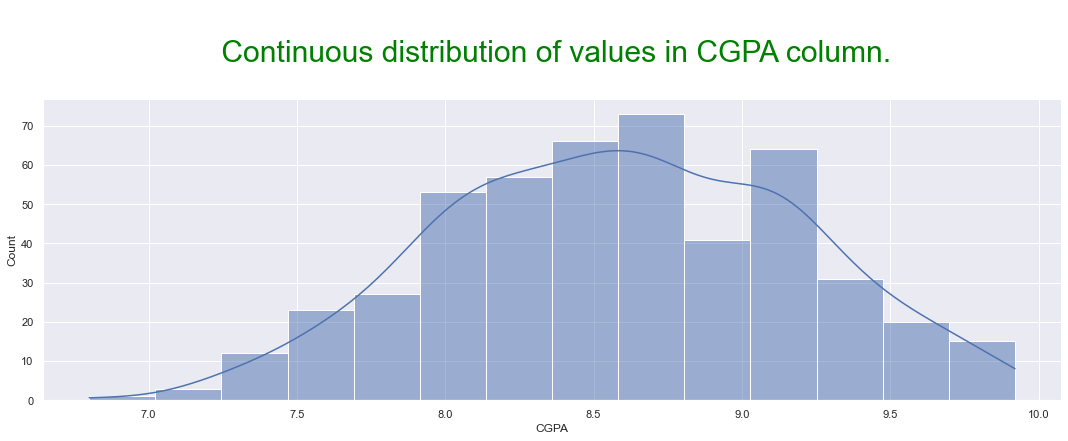

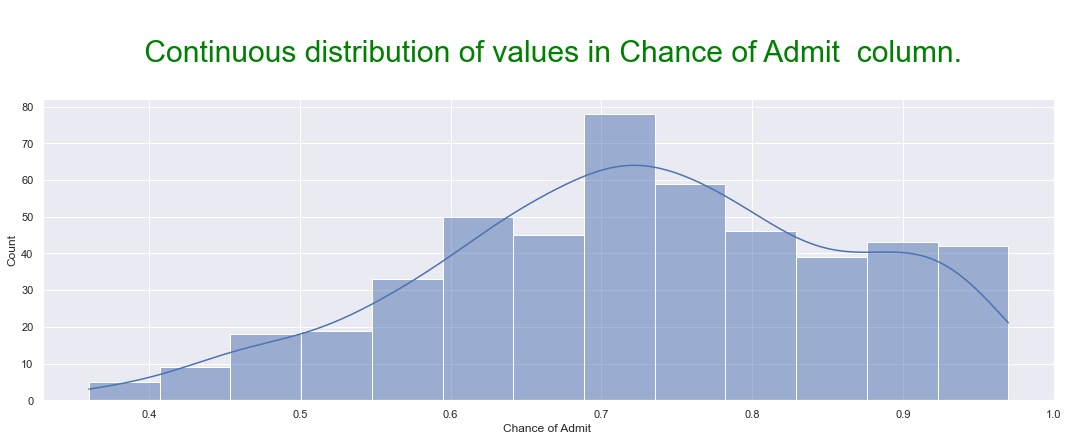

In [17]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **7. Bivariate Analysis.**

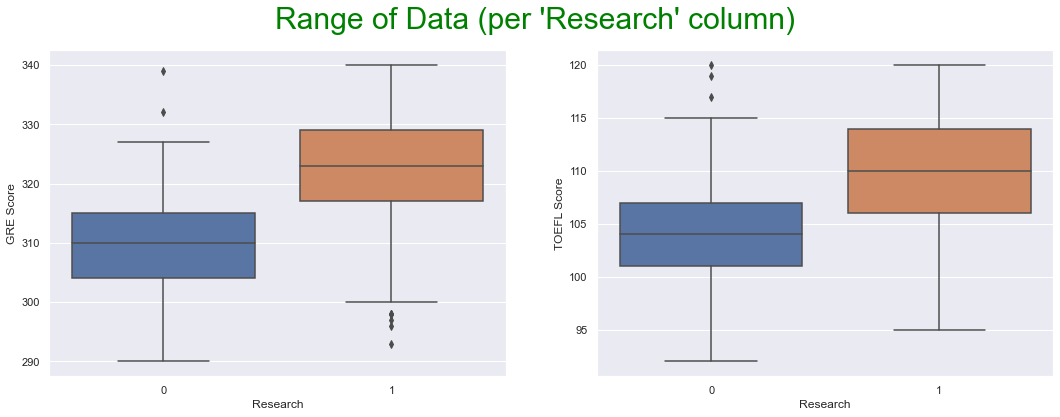

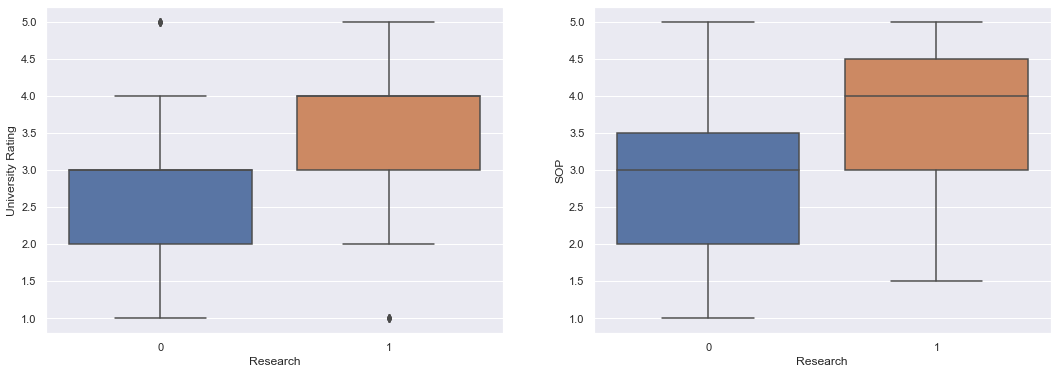

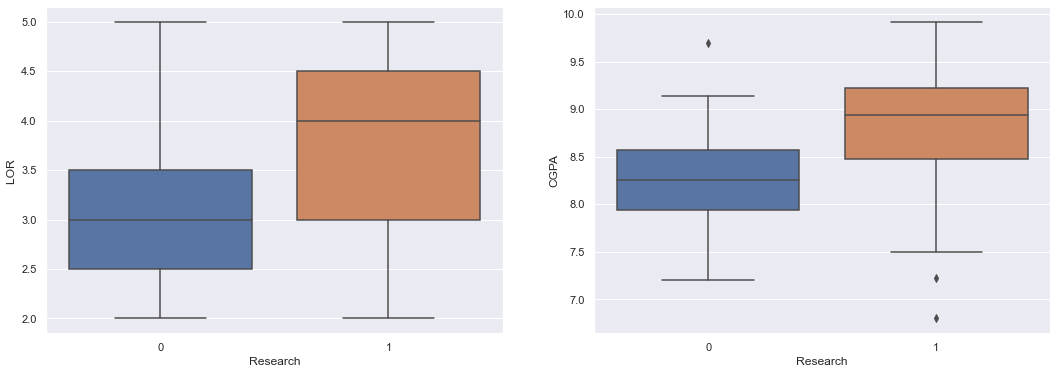

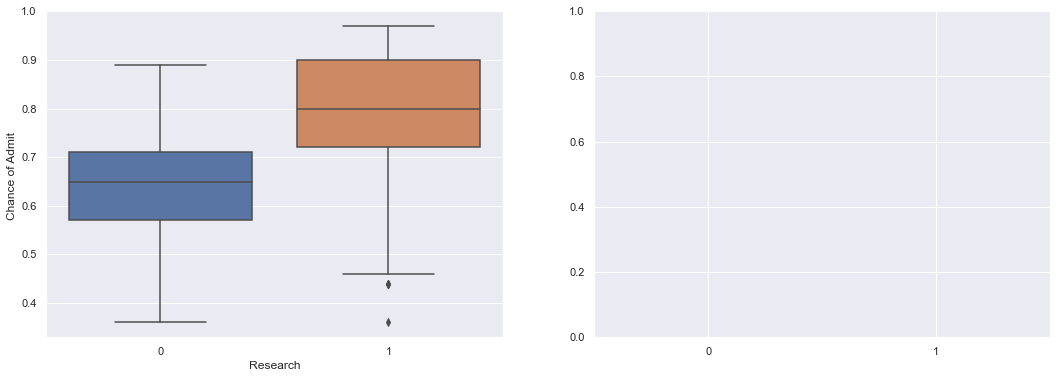

In [18]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **8. Analysis of Correlation Between Data.**

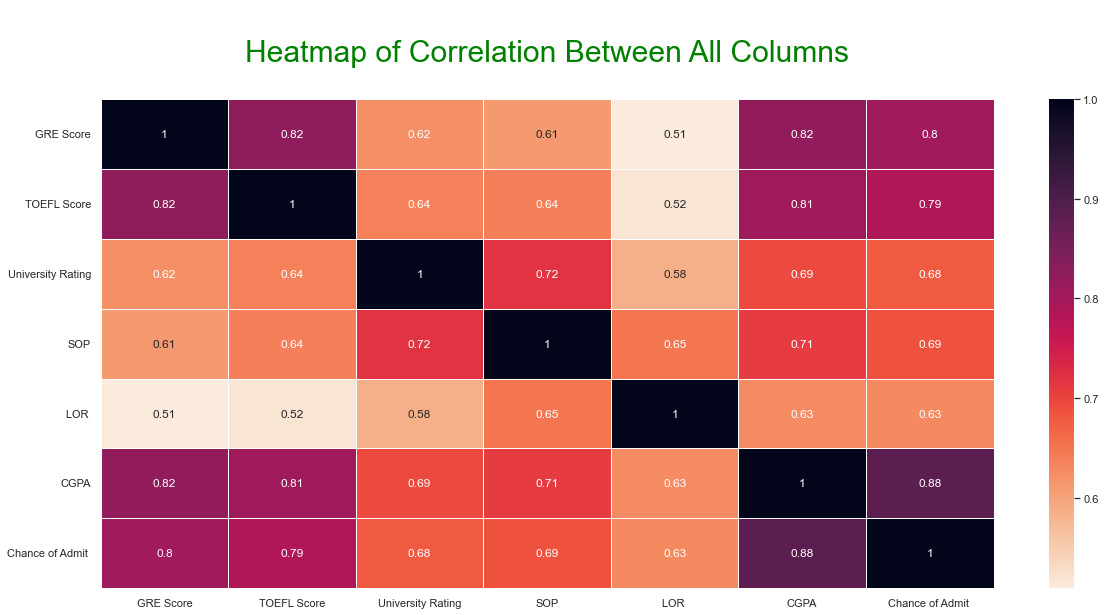

In [19]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **9. Comparison of Chance of Admit for Researchers and Non-Researchers using Hypothesis Testing.**

In [20]:
researcher = df[df['Research']==1]['Chance of Admit ']
nonresearcher = df[df['Research']==0]['Chance of Admit ']

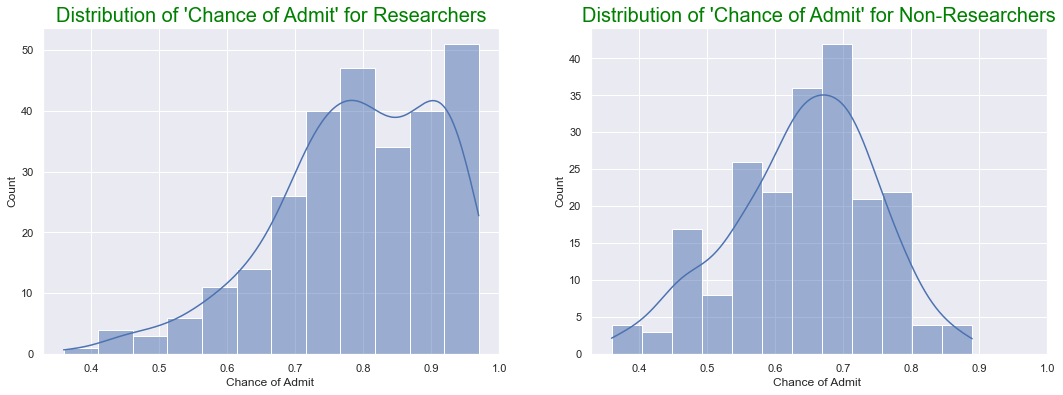

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(researcher, kde=True, ax=axes[0]).set_title("Distribution of 'Chance of Admit' for Researchers", fontsize=20, color="green")
sns.histplot(nonresearcher, kde=True, ax=axes[1]).set_title("Distribution of 'Chance of Admit' for Non-Researchers", fontsize=20, color="green")
plt.show()

***
### Even though, none of the transformations are making data visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [22]:
np.std(researcher)**2, np.std(nonresearcher)**2

(0.01488961670294151, 0.01099387376662624)

***
### Even though, the variances are not equal, still proceeding further with the t-test since the sample size is significantly large.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference for 'Chance of Admit' between unpaired observations for 'Researchers' and 'Non-Researchers' is zero.
### **H1** = The mean difference for 'Chance of Admit' between unpaired observations for 'Researchers' is grater than 'Non-Researchers'.

### **Significance Level (α)** = 0.05

In [23]:
stats.ttest_ind(researcher.sample(100), nonresearcher.sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=9.592285829952534, pvalue=2.155661521125696e-18)

In [24]:
stats.ks_2samp(researcher.sample(100), nonresearcher.sample(100))

KstestResult(statistic=0.56, pvalue=8.771130313572204e-15)

***
### Rejected null hypothesis as the p-value is less than the significance level.

***
***
## **10. Applying 'Min-Max Scaler' on all Numerical columns and One-Hot Encoding on Categorical columns.**

In [25]:
for column in get_columns_by_types(df, categorical_types):
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(column, inplace=True, axis=1)
    df.drop(df.columns[-1], inplace=True, axis=1)
for column in get_columns_by_types(df, numeric_types):
    df[[column]] = minmaxscaler.fit_transform(df[[column]])

In [26]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_0
0,0.94,0.928571,0.75,0.875,0.833333,0.913462,0.918033,0
1,0.68,0.535714,0.75,0.750,0.833333,0.663462,0.655738,0
2,0.52,0.428571,0.50,0.500,0.500000,0.384615,0.590164,0
3,0.64,0.642857,0.50,0.625,0.166667,0.599359,0.721311,0
4,0.48,0.392857,0.25,0.250,0.333333,0.451923,0.475410,1


***
***
## **11. Checking Linearity of variables.**

In [27]:
label = df[['Chance of Admit ']]
features = df.drop('Chance of Admit ', axis=1)

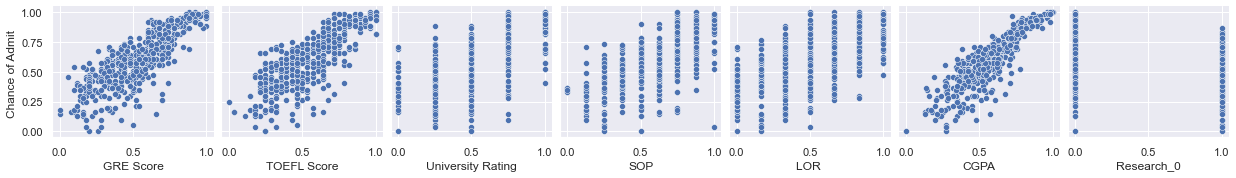

In [28]:
sns.pairplot(data=df, x_vars=features.columns, y_vars=label.columns);

***
***
## **12. Multicollinearity check by VIF score.**

In [29]:
features, vif_resultset = vif_pruning(features, vif_threshold = 10)
print(vif_resultset)

   VIF Score        Column Name           Result
0      28.98          GRE Score  Dropping column
1      23.05        TOEFL Score  Dropping column
2      11.47  University Rating  Dropping column
3      16.03                SOP  Dropping column
4       6.75               LOR    Keeping column
5       7.36               CGPA   Keeping column
6       1.35         Research_0   Keeping column


***
***
## **13. Checking mean of residuals.**

In [30]:
features = sm.add_constant(features)
features.head()

,const,LOR,CGPA,Research_0
0,1.0,0.833333,0.913462,0
1,1.0,0.833333,0.663462,0
2,1.0,0.500000,0.384615,0
3,1.0,0.166667,0.599359,0
4,1.0,0.333333,0.451923,1


In [31]:
model = sm.OLS(label, features)
model_result = model.fit()
print(f'Mean of the residuals is {round(model_result.resid.mean(), 2)}')

Mean of the residuals is 0.0


***
***
## **14. Checking Normality of residuals.**

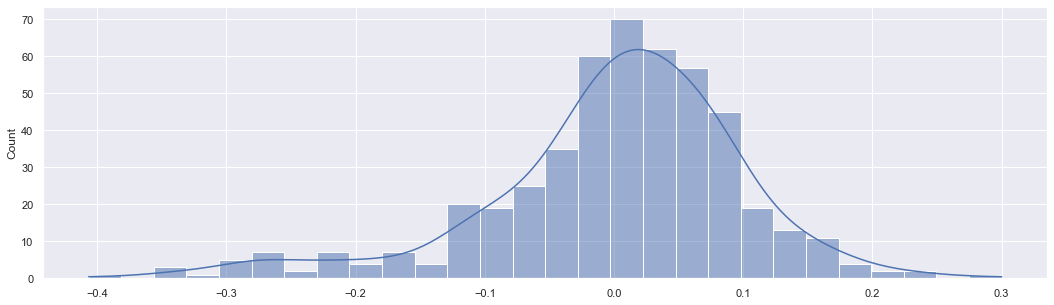

In [32]:
fig, axes = plt.subplots(figsize=(18,5))
sns.histplot(model_result.resid, kde=True);

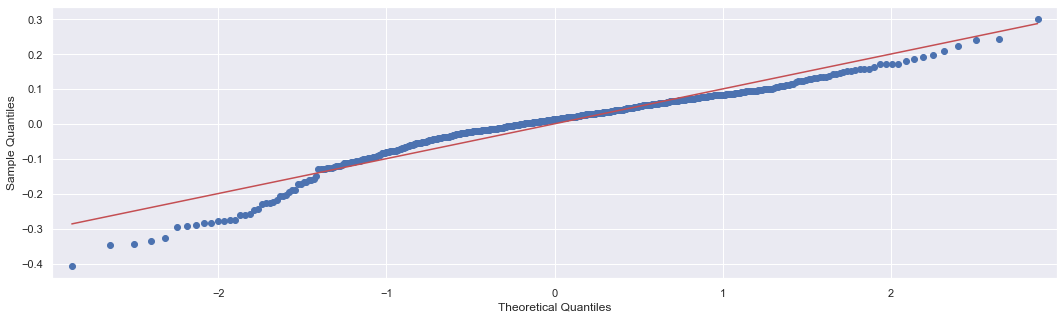

In [33]:
fig, axes = plt.subplots(figsize=(18,5))
sm.qqplot(model_result.resid, line='s', ax=axes);

***
***
## **15. Checking for Homoskedasticity and patterns in residual plot.**

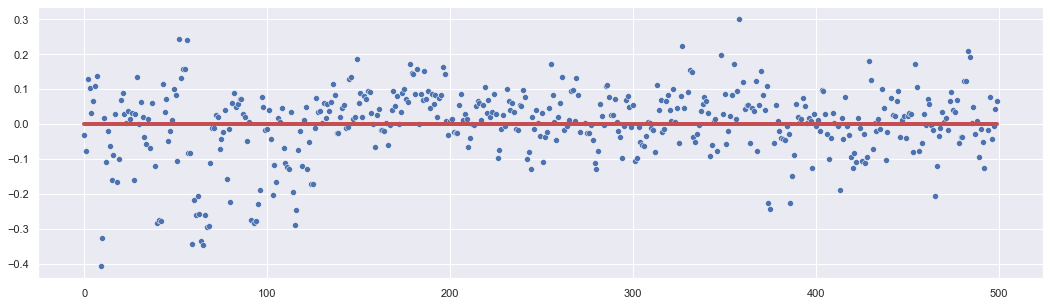

In [34]:
fig, axes = plt.subplots(figsize=(18,5))
sns.lineplot(x=model_result.resid.index, y=[0 for x in model_result.resid], color='r', linewidth=4)
sns.scatterplot(x=model_result.resid.index, y=model_result.resid);

In [35]:
f_stat, p_value, trend = sms.het_goldfeldquandt(model_result.resid, features)
print(f'P value for Goldfeld Quandt Test is {p_value}')

P value for Goldfeld Quandt Test is 0.9999999978863606


***
***
## **16. Model performance evaluation.**

### **A. On training Data**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=0, train_size = .7)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     473.3
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          2.95e-120
Time:                        20:18:38   Log-Likelihood:                 302.00
No. Observations:                 340   AIC:                            -596.0
Df Residuals:                     336   BIC:                            -580.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0954      0.023      4.103      0.0

### **B. On test Data**

In [37]:
model_performance(model, X_test, y_test)

,Metric Name,Metric Score
0,R Squared,0.777499
1,Adjusted R Squared,0.775648
2,Mean Absolute Error,0.070909
3,Mean Squared Error,0.010173
4,Root Mean Squared Error,0.100859


***
***
## **17. Performing Ridge Regression.**

In [38]:
features_columns = features.columns[1:]
label = df[['Chance of Admit ']]
features = df[features_columns]
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=0, train_size = .7)
for alpha in [0.1, 0.2, 0.5, 1.0]:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    print(f"\n\n==============================================================================\n\
                       Model Performance with Alpha value {alpha}.\n"+
                "==============================================================================\n", 
          model_performance(model, X_test, y_test))



                       Model Performance with Alpha value 0.1.
                Metric Name  Metric Score
0                R Squared      0.776700
1       Adjusted R Squared      0.775311
2      Mean Absolute Error      0.071080
3       Mean Squared Error      0.010209
4  Root Mean Squared Error      0.101040


                       Model Performance with Alpha value 0.2.
                Metric Name  Metric Score
0                R Squared      0.775771
1       Adjusted R Squared      0.774376
2      Mean Absolute Error      0.071313
3       Mean Squared Error      0.010252
4  Root Mean Squared Error      0.101250


                       Model Performance with Alpha value 0.5.
                Metric Name  Metric Score
0                R Squared      0.772344
1       Adjusted R Squared      0.770927
2      Mean Absolute Error      0.072355
3       Mean Squared Error      0.010408
4  Root Mean Squared Error      0.102021


                       Model Performance with Alpha value 1.0.

***
***
## **18. Performing Lasso Regression.**

In [39]:
label = df[['Chance of Admit ']]
features = df[features_columns]
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=0, train_size = .7)
for alpha in [0.1, 0.2, 0.5, 1.0]:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    print(f"\n\n==============================================================================\n\
                       Model Performance with Alpha value {alpha}.\n"+
                "==============================================================================\n", 
          model_performance(model, X_test, y_test))



                       Model Performance with Alpha value 0.1.
                Metric Name  Metric Score
0                R Squared     -0.017484
1       Adjusted R Squared     -0.023817
2      Mean Absolute Error      0.173501
3       Mean Squared Error      0.046519
4  Root Mean Squared Error      0.215682


                       Model Performance with Alpha value 0.2.
                Metric Name  Metric Score
0                R Squared     -0.017484
1       Adjusted R Squared     -0.023817
2      Mean Absolute Error      0.173501
3       Mean Squared Error      0.046519
4  Root Mean Squared Error      0.215682


                       Model Performance with Alpha value 0.5.
                Metric Name  Metric Score
0                R Squared     -0.017484
1       Adjusted R Squared     -0.023817
2      Mean Absolute Error      0.173501
3       Mean Squared Error      0.046519
4  Root Mean Squared Error      0.215682


                       Model Performance with Alpha value 1.0.

***
***
## **19. Business Insights.**
#### **A.** There are more students with Research experience compared to students without Research experience.
#### **B.** Researchers have significantly more chances of admission compared to the Non-Researchers with 95% of confidence.
#### **C.** Students with Research experience have higher GRE Score, TOEFL Score and CGPA compared to Non-Researchers.
#### **D.** Students with Research experience study in Universiies with higher ratings compared to Non-Researchers.
#### **E.** There is a very high correlation between GRE Score, TOEFL Score and CGPA.
#### **F.** There is a high correlation between University Ratings, CGPA and SOP.
#### **G.** Target variable 'Chance of admit' has high correlation with all the features.
#### **H.** GRE Score, TOEFL Score, University  Ratings and SOP Strength columns have muticolinearity.
#### **I.** Mean of Residuals is 0 and follows normal distribution.
#### **J.** Distribution of Residuals is Homoscedastic.
#### **K.** OLS model performs good with R-Squared value of 0.77 on test data.
#### **L.** OLS model has R-Squared value equal to the Adjusted R-Squared implying that all the chosen predictors are significant.
#### **M.** Ridge Regression model performs equally well with different alpha values compared to the OLS model.
#### **N.** Lasso Regression model performs worse with different alpha values compared to the OLS model.

***
***
## **20. Recommendations.**
#### **A.** To predict Admission chances of a student, CGPA, Research Experience and LOR columns should be considered. The remaining columns introduce multicolinearity.
#### **B.** Students should be encouraged to maintain a higher CGPA Score throughout all the years, so as to improve their chances of admission, since it is the most significant predictor with coefficient value as 0.85.
#### **C.** Students should be encouraged to obtain some Research Experience so as to improve their chances of admission.
#### **D.** Students should spend some efforts to write strong LORs and SOPs so as to improve their 'Chances of Admission'.
#### **E.** Students should focus on obtaining higher GRE and TOEFL score as it has higher positive correlation (0.8 and 0.79) with the 'Chances of Admission'.
#### **F.** Factors such as demographics, coursework and extracurriculars should also be considered and tested for their effect on the 'Chances of Admission' for improving the prediction model.